# Imports 

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Define device for torch
use_cuda = True
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA is available: False


# Load Dataset
WELFake from HuggingFace

In [3]:
from datasets import load_dataset

dataset = load_dataset("lelexuanzz/WELFake_stylo_feats")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'has_quotes', 'has_url', 'percent_uppercase', 'frequency_punctuation', 'percent_whitespace', 'frequency_words_length_15', 'frequency_words_length_14', 'frequency_words_length_12', 'frequency_words_length_11', 'avg_sentence_length', 'has_1_to_3_urls', 'has_4_to_6_urls', 'has_more_than_6_urls', 'num_exclamations', 'num_questions', 'avg_word_length', 'lexical_diversity', 'proportion_stopwords'],
        num_rows: 70793
    })
})


## Split dataset

In [4]:
#convert dataset to pandas for easier implementation with sklearn

df = dataset["train"].to_pandas()
print(df)

                                                    text  label  has_quotes  \
0      No comment is expected from Barack Obama Membe...      1           0   
1       Now, most of the demonstrators gathered last ...      1           0   
2      A dozen politically active pastors came here f...      0           0   
3      The RS-28 Sarmat missile, dubbed Satan 2, will...      1           0   
4      All we can say on this one is it s about time ...      1           0   
...                                                  ...    ...         ...   
70788  WASHINGTON (Reuters) - Hackers believed to be ...      0           0   
70789  You know, because in fantasyland Republicans n...      1           0   
70790  Migrants Refuse To Leave Train At Refugee Camp...      0           1   
70791  MEXICO CITY (Reuters) - Donald Trump’s combati...      0           0   
70792  Goldman Sachs Endorses Hillary Clinton For Pre...      1           0   

       has_url  percent_uppercase  frequency_punctu

In [5]:
from sklearn.model_selection import train_test_split

seed = 45

y = df["label"]
x = df.drop(labels=["label", "text"], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

print(x_train, y_train)

       has_quotes  has_url  percent_uppercase  frequency_punctuation  \
33090           0        0           4.365983                     42   
13814           0        1           2.970607                     70   
47609           0        0           3.880804                     29   
30722           0        0           3.251016                     67   
1945            0        1           2.789491                     77   
...           ...      ...                ...                    ...   
12895           0        1           3.202995                     61   
60960           0        1           2.864939                     32   
6012            0        1          17.731959                     11   
63107           0        0           3.806452                     30   
6558            0        0           5.263158                      4   

       percent_whitespace  frequency_words_length_15  \
33090           16.362946                          0   
13814           16.8230

### Training

no further preprocessing

In [6]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

In [7]:
# scale features
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [8]:
# instantiate with default params first
gnb = GaussianNB()
gnb.fit(x_train_scaled, y_train)

GaussianNB()

In [9]:
# predict
y_pred = gnb.predict(x_test_scaled)

In [10]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.6346493396426302


In [11]:
# classification report (precision, recall, f1)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.92      0.71      7006
           1       0.82      0.35      0.49      7153

    accuracy                           0.63     14159
   macro avg       0.70      0.64      0.60     14159
weighted avg       0.70      0.63      0.60     14159



## Visualize feature importance
Feature Importance Formula for GaussianNB:
Feature Importance ≈ |mean₀ − mean₁| / √(var₀ + var₁)

Where:
- mean₀: Mean of feature values for class 0
- mean₁: Mean of feature values for class 1
- var₀: Variance of feature values for class 0
- var₁: Variance of feature values for class 1

This formula captures the difference between class distributions and scales it by how spread out the data is in each class.

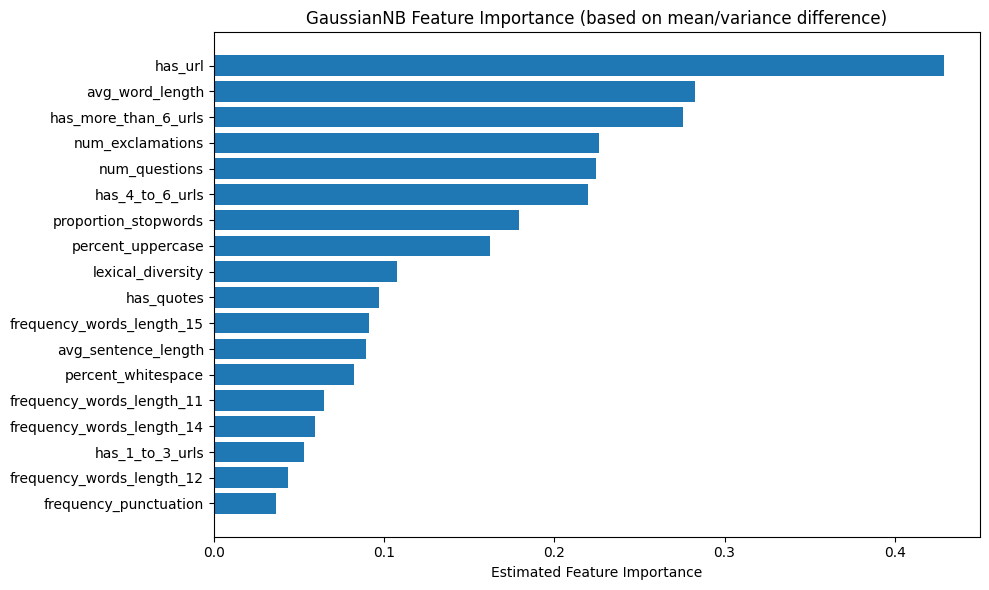

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Feature Importance ≈ |mean₀ − mean₁| / √(var₀ + var₁)
mean_diff = np.abs(gnb.theta_[0] - gnb.theta_[1])  # absolute difference in means
var_sum = np.sqrt(gnb.var_[0] + gnb.var_[1])       # combined std dev
importance_scores = mean_diff / var_sum            # signal-to-noise ratio

# Sort scores and plot
features = x_train.columns
sorted_idx = np.argsort(importance_scores)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(features[sorted_idx], importance_scores[sorted_idx])
plt.xlabel("Estimated Feature Importance")
plt.title("GaussianNB Feature Importance (based on mean/variance difference)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## Cross Validation

## Hyperparameter Tuning

In [13]:
#randomizedsearchcv - includes cross validation
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'var_smoothing': np.logspace(-11, -7, num=100)  # Try values from 1e-11 to 1e-7
}

rand_search = RandomizedSearchCV(
    gnb,
    param_distributions=param_dist,
    n_iter=5,              
    cv=5,                   
    random_state=seed             
)

# Fit the model on training data
rand_search.fit(x_train_scaled, y_train)

RandomizedSearchCV(cv=5, estimator=GaussianNB(), n_iter=5,
                   param_distributions={'var_smoothing': array([1.00000000e-11, 1.09749877e-11, 1.20450354e-11, 1.32194115e-11,
       1.45082878e-11, 1.59228279e-11, 1.74752840e-11, 1.91791026e-11,
       2.10490414e-11, 2.31012970e-11, 2.53536449e-11, 2.78255940e-11,
       3.05385551e-11, 3.35160265e-11, 3.67837977e-11, 4.03701726e-11,
       4.43062146...
       1.17681195e-08, 1.29154967e-08, 1.41747416e-08, 1.55567614e-08,
       1.70735265e-08, 1.87381742e-08, 2.05651231e-08, 2.25701972e-08,
       2.47707636e-08, 2.71858824e-08, 2.98364724e-08, 3.27454916e-08,
       3.59381366e-08, 3.94420606e-08, 4.32876128e-08, 4.75081016e-08,
       5.21400829e-08, 5.72236766e-08, 6.28029144e-08, 6.89261210e-08,
       7.56463328e-08, 8.30217568e-08, 9.11162756e-08, 1.00000000e-07])},
                   random_state=45)

In [14]:
# Best model after grid search
gaussian_model = rand_search.best_estimator_
print(f"Best Hyperparameters: {rand_search.best_params_}")

Best Hyperparameters: {'var_smoothing': np.float64(1e-11)}


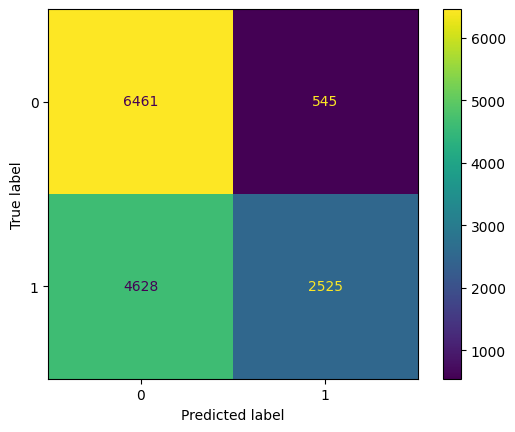

In [15]:
# Generate predictions with the best model
y_pred_best = gaussian_model.predict(x_test_scaled)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_best)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [16]:
accuracy = accuracy_score(y_test, y_pred_best)
precision = precision_score(y_test, y_pred_best)
recall = recall_score(y_test, y_pred_best)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6346493396426302
Precision: 0.8224755700325733
Recall: 0.35299874178666296


## Results on test set

In [17]:
test_dataset = load_dataset("lelexuanzz/Gossipcop_Politifact_Test_Stylo")
print(test_dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'has_quotes', 'has_url', 'percent_uppercase', 'frequency_punctuation', 'percent_whitespace', 'frequency_words_length_15', 'frequency_words_length_14', 'frequency_words_length_12', 'frequency_words_length_11', 'avg_sentence_length', 'has_1_to_3_urls', 'has_4_to_6_urls', 'has_more_than_6_urls', 'num_exclamations', 'num_questions', 'avg_word_length', 'lexical_diversity', 'proportion_stopwords'],
        num_rows: 6900
    })
})


In [18]:
test_df = test_dataset["train"].to_pandas()
display(test_df)


y_test_set = test_df["label"]
x_test_set = test_df.drop(labels=["label", "text"], axis=1)

display(x_test_set)
display(y_test_set)

,text,label,has_quotes,has_url,percent_uppercase,frequency_punctuation,percent_whitespace,frequency_words_length_15,frequency_words_length_14,frequency_words_length_12,frequency_words_length_11,avg_sentence_length,has_1_to_3_urls,has_4_to_6_urls,has_more_than_6_urls,num_exclamations,num_questions,avg_word_length,lexical_diversity,proportion_stopwords
0,The media reported on “5 TikTok dances you can...,0,1,0,5.102041,32,17.040816,0,1,0,3,14.916667,0,0,0,0,2,4.482558,0.651163,0.401163
1,"""Over 240,000 'unverified' ballots have alread...",0,1,0,3.068897,181,15.636029,4,6,26,10,18.271186,0,0,0,2,0,5.078619,0.390221,0.423778
2,"Says ""Ron Johnson is making excuses for rioter...",1,1,1,3.742204,224,16.468666,0,3,12,7,16.619718,0,0,1,3,2,4.761525,0.428191,0.425532
3,“We have seen over the last 10 years ... under...,0,1,1,3.492849,107,16.529153,0,2,3,7,16.410256,0,1,0,0,0,4.758564,0.409462,0.419250
4,“I don’t get involved in the hiring and firing...,0,1,0,3.040541,139,16.394026,3,10,1,16,19.816327,0,0,0,0,0,4.737173,0.387435,0.409424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6895,Wedding Album: Dancing with the Stars Pro Lind...,0,0,0,7.645260,5,18.042813,0,0,0,1,20.666667,0,0,0,1,0,4.283333,0.816667,0.483333
6896,WATCH: Sneak Peek: Arizona's Furious Alex Atta...,0,0,0,9.923664,25,16.793893,0,0,0,0,23.000000,0,0,0,1,0,4.216495,0.690722,0.371134
6897,Mary Kay Letourneau 'Hopeful' She Can Fix Marr...,0,0,0,3.754171,94,15.656285,0,1,5,1,16.216216,0,0,0,0,1,4.602585,0.500808,0.462036
6898,Charlize Theron still upset Aeon Flux didn’t w...,0,0,0,3.329065,36,17.669654,0,0,0,1,18.250000,0,0,0,0,0,4.104730,0.577703,0.483108


,has_quotes,has_url,percent_uppercase,frequency_punctuation,percent_whitespace,frequency_words_length_15,frequency_words_length_14,frequency_words_length_12,frequency_words_length_11,avg_sentence_length,has_1_to_3_urls,has_4_to_6_urls,has_more_than_6_urls,num_exclamations,num_questions,avg_word_length,lexical_diversity,proportion_stopwords
0,1,0,5.102041,32,17.040816,0,1,0,3,14.916667,0,0,0,0,2,4.482558,0.651163,0.401163
1,1,0,3.068897,181,15.636029,4,6,26,10,18.271186,0,0,0,2,0,5.078619,0.390221,0.423778
2,1,1,3.742204,224,16.468666,0,3,12,7,16.619718,0,0,1,3,2,4.761525,0.428191,0.425532
3,1,1,3.492849,107,16.529153,0,2,3,7,16.410256,0,1,0,0,0,4.758564,0.409462,0.419250
4,1,0,3.040541,139,16.394026,3,10,1,16,19.816327,0,0,0,0,0,4.737173,0.387435,0.409424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6895,0,0,7.645260,5,18.042813,0,0,0,1,20.666667,0,0,0,1,0,4.283333,0.816667,0.483333
6896,0,0,9.923664,25,16.793893,0,0,0,0,23.000000,0,0,0,1,0,4.216495,0.690722,0.371134
6897,0,0,3.754171,94,15.656285,0,1,5,1,16.216216,0,0,0,0,1,4.602585,0.500808,0.462036
6898,0,0,3.329065,36,17.669654,0,0,0,1,18.250000,0,0,0,0,0,4.104730,0.577703,0.483108


0       0
1       0
2       1
3       0
4       0
       ..
6895    0
6896    0
6897    0
6898    0
6899    0
Name: label, Length: 6900, dtype: int64

In [19]:
# scale features
x_test_set_scaled = scaler.transform(x_test_set)

In [20]:
y_test_pred = gaussian_model.predict(x_test_set_scaled)

In [21]:
accuracy = accuracy_score(y_test_set, y_test_pred)
precision = precision_score(y_test_set, y_test_pred)
recall = recall_score(y_test_set, y_test_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5359420289855072
Precision: 0.3646546359676416
Recall: 0.5025728987993139


## Feature Importance and Elimination

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB

# Fit the Gaussian Naive Bayes model
gnb = GaussianNB()
gnb.fit(x_train_scaled, y_train)  # Make sure to scale the features

# Compute feature importance
mean_diff = np.abs(gnb.theta_[0] - gnb.theta_[1])  # absolute difference in means
var_sum = np.sqrt(gnb.var_[0] + gnb.var_[1])       # combined standard deviation
importance_scores = mean_diff / var_sum            # signal-to-noise ratio

# Sort scores and plot
features = x_train.columns
sorted_idx = np.argsort(importance_scores)[::-1]  # Sort importance in descending order

# Output the top features
top_features = features[sorted_idx][:10]
print("Selected Top Features:")
print(top_features)

# Create a ranking DataFrame
ranking_df = pd.DataFrame({
    'feature': features,
    'importance': importance_scores
}).sort_values(by='importance', ascending=False)

print("\nFeature Rankings:")
print(ranking_df)


Selected Top Features:
Index(['has_url', 'avg_word_length', 'has_more_than_6_urls',
       'num_exclamations', 'num_questions', 'has_4_to_6_urls',
       'proportion_stopwords', 'percent_uppercase', 'lexical_diversity',
       'has_quotes'],
      dtype='object')

Feature Rankings:
                      feature  importance
1                     has_url    0.428641
15            avg_word_length    0.282705
12       has_more_than_6_urls    0.275341
13           num_exclamations    0.226466
14              num_questions    0.224632
11            has_4_to_6_urls    0.219872
17       proportion_stopwords    0.179353
2           percent_uppercase    0.162200
16          lexical_diversity    0.107635
0                  has_quotes    0.096977
5   frequency_words_length_15    0.090902
9         avg_sentence_length    0.089535
4          percent_whitespace    0.082286
8   frequency_words_length_11    0.064478
6   frequency_words_length_14    0.059528
10            has_1_to_3_urls    0.052685
7  

## Train with top features after Recursive Feature Elimination

In [26]:
display(x_train[top_features])

,has_url,avg_word_length,has_more_than_6_urls,num_exclamations,num_questions,has_4_to_6_urls,proportion_stopwords,percent_uppercase,lexical_diversity,has_quotes
33090,0,5.108747,0,0,0,0,0.442080,4.365983,0.524823,0
13814,1,4.761029,0,0,1,0,0.496324,2.970607,0.529412,0
47609,0,4.966102,0,0,0,0,0.457627,3.880804,0.635593,0
30722,0,4.641441,0,0,2,0,0.452252,3.251016,0.533333,0
1945,1,4.785441,1,0,0,0,0.440613,2.789491,0.519157,0
...,...,...,...,...,...,...,...,...,...,...
12895,1,4.349315,0,1,0,0,0.529680,3.202995,0.531963,0
60960,1,4.720317,0,0,1,0,0.480211,2.864939,0.527704,0
6012,1,4.827160,0,0,1,0,0.382716,17.731959,0.777778,0
63107,0,4.551471,0,0,0,0,0.477941,3.806452,0.547794,0


In [33]:
rand_search.fit(x_train[top_features], y_train)

best_gaussian_rfe = rand_search.best_estimator_
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'var_smoothing': np.float64(1e-11)}


In [34]:
y_pred_rfe = best_gaussian_rfe.predict(x_test[top_features])

In [35]:
accuracy = accuracy_score(y_test, y_pred_rfe)
precision = precision_score(y_test, y_pred_rfe)
recall = recall_score(y_test, y_pred_rfe)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6725051204181086
Precision: 0.796
Recall: 0.4729484132531805


### Results on test set

In [37]:
y_test_rfe = best_gaussian_rfe.predict(x_test_set[top_features])

In [38]:
accuracy = accuracy_score(y_test_set, y_test_rfe)
precision = precision_score(y_test_set, y_test_rfe)
recall = recall_score(y_test_set, y_test_rfe)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5031884057971014
Precision: 0.3627254509018036
Recall: 0.6209262435677531


## Save best model

In [39]:
import pickle

pickle.dump(gaussian_model, open("models/iter2_gaussian", 'wb'))

In [26]:
#test to see if model can be loaded

loaded_model = pickle.load(open('models/iter1_gaussian', 'rb'))

load_predict = loaded_model.predict(x_test_set_scaled)

accuracy = accuracy_score(y_test_set, load_predict)
precision = precision_score(y_test_set, load_predict)
recall = recall_score(y_test_set, load_predict)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5127536231884058
Precision: 0.38995726495726496
Recall: 0.782590051457976
